# Modelo Random Forest

### Importar Librerías

In [2]:
import pandas as pd
from pandas import DataFrame, concat
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
from sklearn.model_selection import GridSearchCV, PredefinedSplit, TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import randint

import warnings
warnings.filterwarnings("ignore")

### 1. Cargar Datos

In [14]:
file_path = r"..\Modelling\data.csv"
data = pd.read_csv(file_path)
data['Fecha'] = pd.to_datetime(data['Fecha'])
data.set_index('Fecha', inplace=True)
data

,Ventas,Festivo,IsWeekend,DiaSemanaNum,DiaSemana_0,DiaSemana_1,DiaSemana_2,DiaSemana_3,DiaSemana_4,DiaSemana_5,DiaSemana_6,Ventas_Log,Ventas_Loess,Ventas_Log_Loess
Fecha,,,,,,,,,,,,,,
2021-11-02,80413.11,0,0,1,0,1,0,0,0,0,0,11.294945,29692.704031,10.116158
2021-11-03,14889.17,0,0,2,0,0,1,0,0,0,0,9.608457,29674.201652,10.115608
2021-11-04,50003.14,0,0,3,0,0,0,1,0,0,0,10.819861,29656.031451,10.115075
2021-11-05,39607.01,0,0,4,0,0,0,0,1,0,0,10.586787,29638.193546,10.114560
2021-11-06,0.00,0,1,5,0,0,0,0,0,1,0,0.000000,29620.685373,10.114062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-27,305.76,0,1,5,0,0,0,0,0,1,0,5.726066,15205.174613,9.351941
2024-07-28,114.40,0,1,6,0,0,0,0,0,0,1,4.748404,15183.946452,9.350883
2024-07-29,14466.95,0,0,0,1,0,0,0,0,0,0,9.579691,15162.718291,9.349824


In [15]:
test_days = 101 # Coincide con el train-test split del Análisis exploratorio

### 2. Definir Clases para entrenamiento con GridSearch

#### 2.1. Random Forest

In [16]:
class RandomForestTimeSeries:
    def __init__(self, data, target='Ventas', test_days=test_days):
        """
        Inicializa la clase con los datos, columna objetivo y tamaño de prueba.

        Parameters:
        - data: DataFrame original.
        - target: Nombre de la variable objetivo (default: 'Ventas').
        - test_days: Número de días para prueba (default: 101).
        """
        self.data = data.copy()
        self.target = target
        self.test_days = test_days

    def preprocess_data(self):
        self.train_data = self.data.iloc[:-self.test_days]
        self.test_data = self.data.iloc[-self.test_days:]

    def create_features(self, df):
        """
        Crea características adicionales:
        - rolling_mean de 7 días.
        - rolling_std de 7 días.
        - lags de 1, 7 y 14 días.
        """
        df = df.copy()

        # Crear rolling mean
        df['rolling_mean_7d'] = (
            df[self.target]
            .rolling(window=7, min_periods=1)
            .mean()
            .fillna(0)  # Reemplazar NaNs por 0
        )

        # Crear rolling std
        df['rolling_std_7d'] = (
            df[self.target]
            .rolling(window=7, min_periods=1)
            .std()
            .fillna(0)  # Reemplazar NaNs por 0
        )

        # Crear lags
        for lag in [1, 7, 14]:
            df[f'lag_{lag}'] = df[self.target].shift(lag).fillna(0)  # Reemplazar NaNs por 0

        return df

    def train_model(self, manual_features=None):
        """
        Entrena el modelo de Random Forest utilizando GridSearchCV.

        Parameters:
        - manual_features: list, características manuales seleccionadas por el usuario.
        Si no se especifica, se utiliza una lista predeterminada.
        """
        # Definir rango de hiperparámetros para GridSearchCV
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt']
        }

        # Instanciar el modelo base
        rf = RandomForestRegressor(random_state=42)

        # Configurar GridSearchCV
        grid_search = GridSearchCV(
            estimator=rf,
            param_grid=param_grid,
            scoring='neg_root_mean_squared_error',
            cv=3,
            verbose=1,
            n_jobs=-1
        )

        # Aplicar create_features para generar las variables adicionales
        self.train_data = self.create_features(self.train_data)
        self.test_data = self.create_features(self.test_data)

        # Usar las manual features proporcionadas o la lista predeterminada
        if manual_features is None:
            manual_features = [
                'Festivo', 'IsWeekend', 'DiaSemana_0', 'DiaSemana_1',
                'DiaSemana_2', 'DiaSemana_3', 'DiaSemana_4', 'DiaSemana_5', 'DiaSemana_6'
            ]
        generated_features = [
            'rolling_mean_7d', 'rolling_std_7d', 'lag_1', 'lag_7', 'lag_14'
        ]
        all_features = manual_features + generated_features

        # Separar las características y la variable objetivo
        X_train = self.train_data[all_features]
        y_train = self.train_data[self.target]

        # Entrenar con GridSearchCV
        grid_search.fit(X_train, y_train)

        # Guardar el mejor modelo y los resultados
        self.best_model = grid_search.best_estimator_
        self.best_params = grid_search.best_params_

        # Evaluar en el conjunto de prueba
        X_test = self.test_data[all_features]
        y_test = self.test_data[self.target]
        y_pred = self.best_model.predict(X_test)
        self.test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        print(f"Mejores hiperparámetros: {self.best_params}")
        print(f"RMSE en el conjunto de prueba: {self.test_rmse}")

        return self.best_model
        
    def predict(self):
        """
        Genera predicciones en el conjunto de prueba utilizando el modelo entrenado.
        """
        if not hasattr(self, 'best_model'):
            raise ValueError("El modelo no está entrenado. Llama a 'train_model()' primero.")
        
        # Definir variables independientes
        manual_features = [
            'Festivo', 'IsWeekend', 'DiaSemana_0', 'DiaSemana_1',
            'DiaSemana_2', 'DiaSemana_3', 'DiaSemana_4', 'DiaSemana_5', 'DiaSemana_6'
        ]
        generated_features = [
            'rolling_mean_7d', 'rolling_std_7d', 'lag_1', 'lag_7', 'lag_14'
        ]
        all_features = manual_features + generated_features

        # Copiar datos de entrenamiento
        train_copy = self.train_data.copy()
        train_copy['isFuture'] = False

        # Crear rango de fechas para el conjunto futuro
        future = pd.date_range(
            start=self.train_data.index.max() + pd.Timedelta(days=1),
            end=self.test_data.index.max(),
            freq='1D'
        )
        future_df = pd.DataFrame(index=future)
        future_df['isFuture'] = True

        # Combinar datos de entrenamiento y futuro
        df_and_future = pd.concat([train_copy, future_df], axis=0)

        # Generar características y manejar posibles NaNs
        df_and_future = self.create_features(df_and_future)
        df_and_future.fillna(0, inplace=True)  # Reemplazar NaNs por 0 para fechas futuras

        # Filtrar solo las fechas futuras
        future_w_features = df_and_future.query('isFuture').copy()

        # Validar que las columnas necesarias existan
        if not all(col in future_w_features.columns for col in all_features):
            raise ValueError("No se generaron todas las características necesarias para las predicciones futuras.")

        # Seleccionar las características y realizar predicciones
        X_future = future_w_features[all_features]
        if X_future.empty:
            raise ValueError("No hay datos futuros disponibles para realizar predicciones.")
        
        future_w_features['pred'] = self.best_model.predict(X_future)
        self.future_w_features_pred = future_w_features
        return self.future_w_features_pred['pred'].to_list()

    def evaluate_model_predictions(self):
        """
        Evalúa el modelo en los conjuntos de entrenamiento y prueba.
        Calcula las métricas RMSE y R², y almacena las predicciones.
        """
        # Definir las columnas para las características
        manual_features = [
            'Festivo', 'IsWeekend', 'DiaSemana_0', 'DiaSemana_1',
            'DiaSemana_2', 'DiaSemana_3', 'DiaSemana_4', 'DiaSemana_5', 'DiaSemana_6'
        ]
        generated_features = [
            'rolling_mean_7d', 'rolling_std_7d', 'lag_1', 'lag_7', 'lag_14'
        ]
        all_features = manual_features + generated_features

        # Separar características y objetivo
        X_train = self.train_data[all_features]
        y_train = self.train_data[self.target]
        X_test = self.test_data[all_features]
        y_test = self.test_data[self.target]

        # Predicciones en el conjunto de entrenamiento
        y_pred_train = self.best_model.predict(X_train)
        self.rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        self.r2_train = r2_score(y_train, y_pred_train)
        self.mae_train = mean_absolute_error(y_train, y_pred_train)

        # Predicciones en el conjunto de prueba
        y_pred_test = self.best_model.predict(X_test)
        self.rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        self.r2_test = r2_score(y_test, y_pred_test)
        self.mae_test = mean_absolute_error(y_test, y_pred_test)

        # Guardar las predicciones como DataFrames
        self.train_forecast_vs_actual = pd.DataFrame({
            'Actual': y_train,
            'Forecast': y_pred_train
        }, index=X_train.index)

        self.test_forecast_vs_actual = pd.DataFrame({
            'Actual': y_test,
            'Forecast': y_pred_test
        }, index=X_test.index)

        # Imprimir métricas
        print(f"RMSE Train: {self.rmse_train}")
        print(f"MAE Train: {self.mae_train}")        
        print(f"R² Train: {self.r2_train}")
        print(f"RMSE Test: {self.rmse_test}")
        print(f"MAE Test: {self.mae_test}")
        print(f"R² Test: {self.r2_test}")

    def generate_model_info(self, version):
        model_info = {
            'version': version,
            'model_name': self.best_model.__class__.__name__,
            'rmse_train': self.rmse_train,
            'mae_train':self.mae_train,
            'r2_train': self.r2_train,
            'rmse_test': self.rmse_test,
            'mae_test': self.mae_test,
            'r2_test': self.r2_test,
        }
        return model_info
    
    def plot_predictions(self, train_title, test_title, divided_title):
        """
        Genera tres gráficos personalizados con títulos proporcionados:
        1. Valores reales vs predicciones en el conjunto de entrenamiento.
        2. Valores reales vs predicciones en el conjunto de prueba.
        3. Gráfico combinado de entrenamiento y prueba con una línea divisoria.
        
        Parameters:
        - train_title: str, título para el gráfico de entrenamiento.
        - test_title: str, título para el gráfico de prueba.
        - divided_title: str, título para el gráfico con línea divisoria.
        """
        # Gráfico 1: Conjunto de entrenamiento
        plt.figure(figsize=(12, 6))
        plt.plot(self.train_forecast_vs_actual.index, self.train_forecast_vs_actual['Actual'], 
                label='Actual (Train)', marker='o', color='#1f77b4', linewidth=2, linestyle='-')
        plt.plot(self.train_forecast_vs_actual.index, self.train_forecast_vs_actual['Forecast'], 
                label='Forecast (Train)', marker='x', color='#ff7f0e', linewidth=2, linestyle='--')
        plt.title(train_title, fontsize=16, fontweight='bold', color='#333')
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Ventas', fontsize=14)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.xticks(rotation=45, ha='right', fontsize=10)
        formatter = ticker.FuncFormatter(lambda x, pos: '${:,.0f}K'.format(x * 1e-3))
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
        plt.gca().set_facecolor('#f9f9f9')
        plt.legend(loc='upper left', fontsize=12)
        plt.tight_layout()
        plt.show()

        # Gráfico 2: Conjunto de prueba
        plt.figure(figsize=(12, 6))
        plt.plot(self.test_forecast_vs_actual.index, self.test_forecast_vs_actual['Actual'], 
                label='Actual (Test)', marker='o', color='#1f77b4', linewidth=2, linestyle='-')
        plt.plot(self.test_forecast_vs_actual.index, self.test_forecast_vs_actual['Forecast'], 
                label='Forecast (Test)', marker='x', color='#ff7f0e', linewidth=2, linestyle='--')
        plt.title(test_title, fontsize=16, fontweight='bold', color='#333')
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Ventas', fontsize=14)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
        plt.gca().set_facecolor('#f9f9f9')
        plt.legend(loc='upper left', fontsize=12)
        plt.tight_layout()
        plt.show()

        # Gráfico 3: Combinado con línea divisoria
        predictions = pd.concat([self.train_forecast_vs_actual['Forecast'], self.test_forecast_vs_actual['Forecast']], axis=0).to_frame(name='Predicted')
        predictions['Actual'] = pd.concat([self.train_forecast_vs_actual['Actual'], self.test_forecast_vs_actual['Actual']], axis=0)
        test_start_index = self.test_forecast_vs_actual.index.min()

        predictions_last_200 = predictions.tail(200)
        plt.figure(figsize=(12, 6))
        plt.plot(predictions_last_200.loc[:test_start_index].index, predictions_last_200.loc[:test_start_index, 'Actual'],
                label='Actual - Train', marker='o', color='#1f77b4', linewidth=2, linestyle='-')
        plt.plot(predictions_last_200.loc[:test_start_index].index, predictions_last_200.loc[:test_start_index, 'Predicted'],
                label='Forecast - Train', marker='x', color='#ff7f0e', linewidth=2, linestyle='--')
        plt.plot(predictions_last_200.loc[test_start_index:].index, predictions_last_200.loc[test_start_index:, 'Actual'],
                label='Actual - Test', marker='o', color='#2ca02c', linewidth=2, linestyle='-')
        plt.plot(predictions_last_200.loc[test_start_index:].index, predictions_last_200.loc[test_start_index:, 'Predicted'],
                label='Forecast - Test', marker='x', color='#d62728', linewidth=2, linestyle='--')

        plt.axvline(test_start_index, color='gray', linestyle='--', linewidth=1.5, label='División Train/Test')
        plt.title(divided_title, fontsize=16, fontweight='bold', color='#333')
        plt.xlabel('Fecha', fontsize=14)
        plt.ylabel('Ventas (USD)', fontsize=14)
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.ylim(0, 120000)  # Ajustar el rango del eje y (mejora visual)
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.gca().yaxis.set_tick_params(labelsize=10)
        plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
        plt.gca().set_facecolor('#f9f9f9')
        plt.legend(loc='upper left', fontsize=12)
        plt.tight_layout()
        plt.show()

#### 2.2. Random Forest Logarítmico

In [17]:
class RandomForestTimeSeriesLog(RandomForestTimeSeries):
    """
    Extiende la funcionalidad de RandomForestTimeSeries para trabajar con un target logarítmico.
    El target debe ser transformado como Log(Ventas) + 1.
    """

    def __init__(self, data, target='Ventas_Log', test_days=test_days):
        """
        Inicializa la clase con los datos, columna objetivo y tamaño de prueba.

        Parameters:
        - data: DataFrame original.
        - target: Nombre de la variable objetivo (default: 'Ventas_Log').
        - test_days: Número de días para prueba (default: 101).
        """
        super().__init__(data, target, test_days)

    def evaluate_model_predictions(self):
        """
        Evalúa el modelo en los conjuntos de entrenamiento y prueba.
        Calcula las métricas RMSE y R², y almacena las predicciones.
        En este caso, invierte la transformación logarítmica: exp(Ventas_Log) - 1.
        """
        # Definir las columnas para las características
        manual_features = [
            'Festivo', 'IsWeekend', 'DiaSemana_0', 'DiaSemana_1',
            'DiaSemana_2', 'DiaSemana_3', 'DiaSemana_4', 'DiaSemana_5', 'DiaSemana_6'
        ]
        generated_features = [
            'rolling_mean_7d', 'rolling_std_7d', 'lag_1', 'lag_7', 'lag_14'
        ]
        all_features = manual_features + generated_features

        # Separar características y objetivo
        X_train = self.train_data[all_features]
        y_train_log = self.train_data[self.target]
        X_test = self.test_data[all_features]
        y_test_log = self.test_data[self.target]

        # Invertir transformación para los valores reales
        y_train = (np.exp(y_train_log) - 1).clip(0)  # Evitar valores negativos por errores numéricos
        y_test = (np.exp(y_test_log) - 1).clip(0)

        # Predicciones en el conjunto de entrenamiento
        y_pred_train_log = self.best_model.predict(X_train)
        y_pred_train = (np.exp(y_pred_train_log) - 1).clip(0)

        # Predicciones en el conjunto de prueba
        y_pred_test_log = self.best_model.predict(X_test)
        y_pred_test = (np.exp(y_pred_test_log) - 1).clip(0)

        # Calcular métricas en entrenamiento
        self.rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        self.mae_train = mean_absolute_error(y_train, y_pred_train)
        self.r2_train = r2_score(y_train, y_pred_train)  
        
        # Calcular métricas en prueba
        self.rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        self.mae_test = mean_absolute_error(y_test, y_pred_test)
        self.r2_test = r2_score(y_test, y_pred_test)  


        # Guardar las predicciones como DataFrames
        self.train_forecast_vs_actual = pd.DataFrame({
            'Actual': y_train,
            'Forecast': y_pred_train
        }, index=X_train.index)

        self.test_forecast_vs_actual = pd.DataFrame({
            'Actual': y_test,
            'Forecast': y_pred_test
        }, index=X_test.index)

        # Imprimir métricas
        print(f"RMSE Train: {self.rmse_train}")
        print(f"MAE Train: {self.mae_train}")        
        print(f"R² Train: {self.r2_train}")
        print(f"RMSE Test: {self.rmse_test}")
        print(f"MAE Test: {self.mae_test}")
        print(f"R² Test: {self.r2_test}")


### 3. Serie sin transformar

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Mejores hiperparámetros: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
RMSE en el conjunto de prueba: 18094.999922006842
RMSE Train: 12982.650651717184
MAE Train: 9312.87742984644
R² Train: 0.7840834268189396
RMSE Test: 18094.999922006842
MAE Test: 12965.147834969026
R² Test: 0.5190194522062519


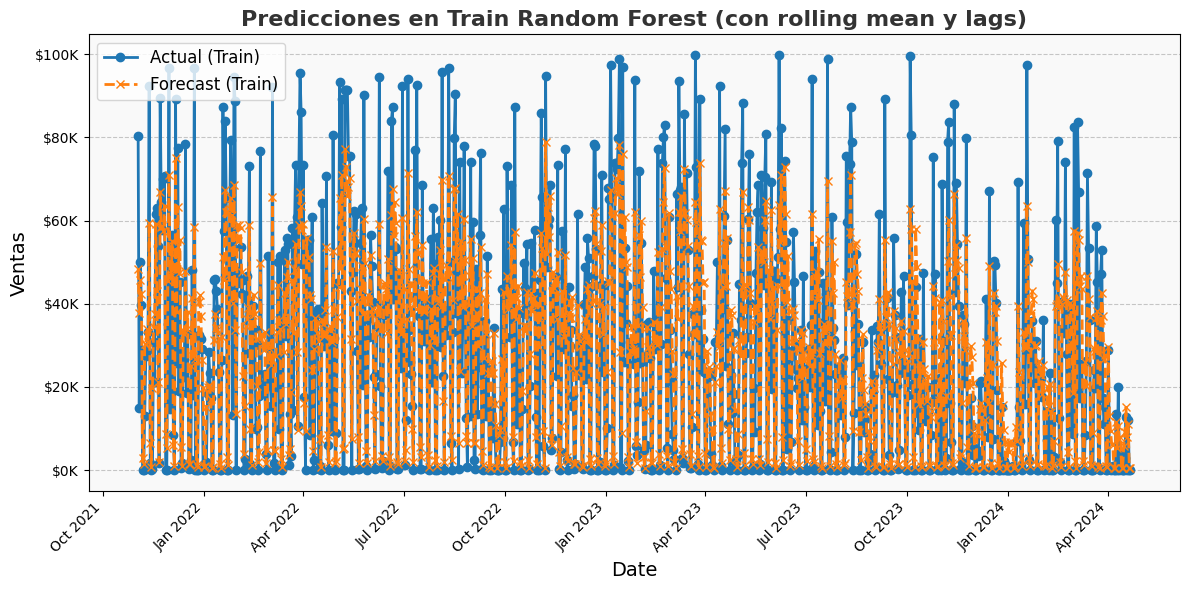

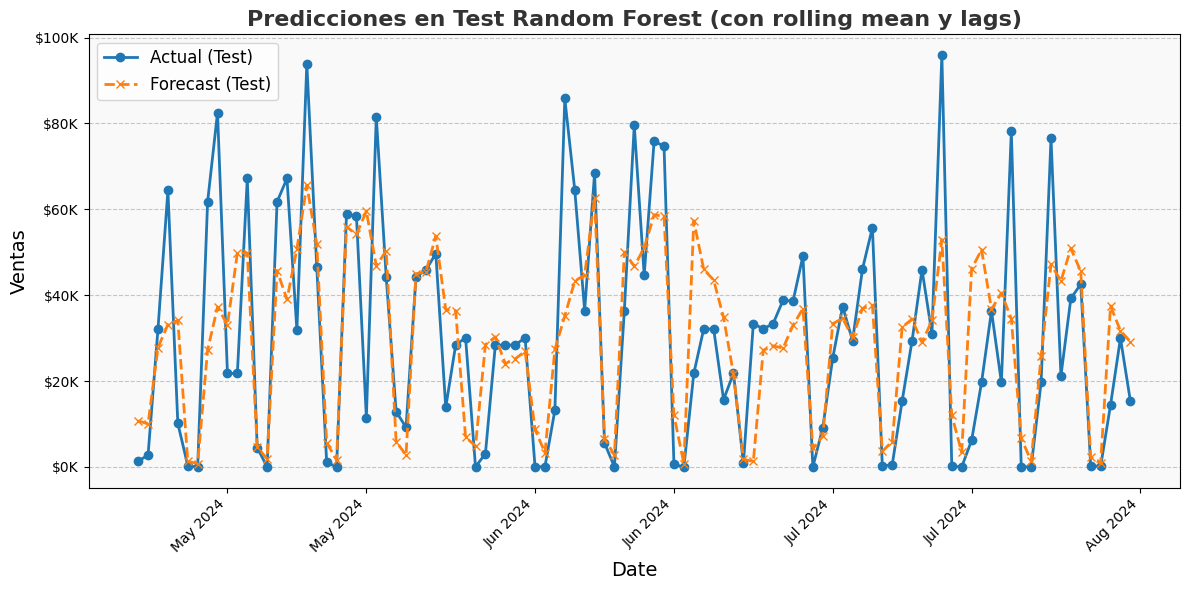

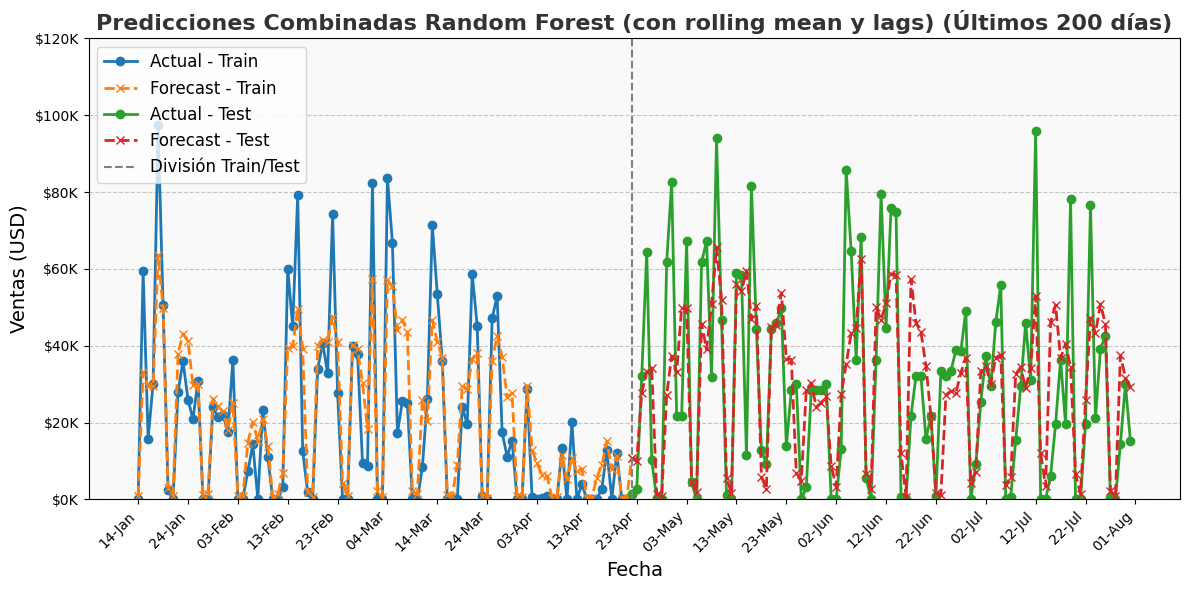

In [9]:
model = RandomForestTimeSeries(data=data, target='Ventas', test_days=101)
model.preprocess_data()
model.train_model(manual_features=['Festivo', 'IsWeekend','DiaSemana_0','DiaSemana_1','DiaSemana_2','DiaSemana_3','DiaSemana_4','DiaSemana_5','DiaSemana_6']) 
model.evaluate_model_predictions()
model.plot_predictions(train_title='Predicciones en Train Random Forest (con rolling mean y lags)',
    test_title='Predicciones en Test Random Forest (con rolling mean y lags)',
    divided_title='Predicciones Combinadas Random Forest (con rolling mean y lags) (Últimos 200 días)'
)

In [10]:
model_info = model.generate_model_info(version='Random Forest')
model_info

{'version': 'Random Forest',
 'model_name': 'RandomForestRegressor',
 'rmse_train': 12982.650651717184,
 'mae_train': 9312.87742984644,
 'r2_train': 0.7840834268189396,
 'rmse_test': 18094.999922006842,
 'mae_test': 12965.147834969026,
 'r2_test': 0.5190194522062519}

In [11]:
df_models_info = pd.DataFrame([model_info]).round(2)
df_models_info

,version,model_name,rmse_train,mae_train,r2_train,rmse_test,mae_test,r2_test
0,Random Forest,RandomForestRegressor,12982.65,9312.88,0.78,18095.0,12965.15,0.52


### 4. Serie Transformada

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Mejores hiperparámetros: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RMSE en el conjunto de prueba: 1.3858914456836449
RMSE Train: 12031.71599534465
MAE Train: 6681.630514850753
R² Train: 0.8145553190493142
RMSE Test: 20360.28767468741
MAE Test: 13557.833086667857
R² Test: 0.39105487027627606


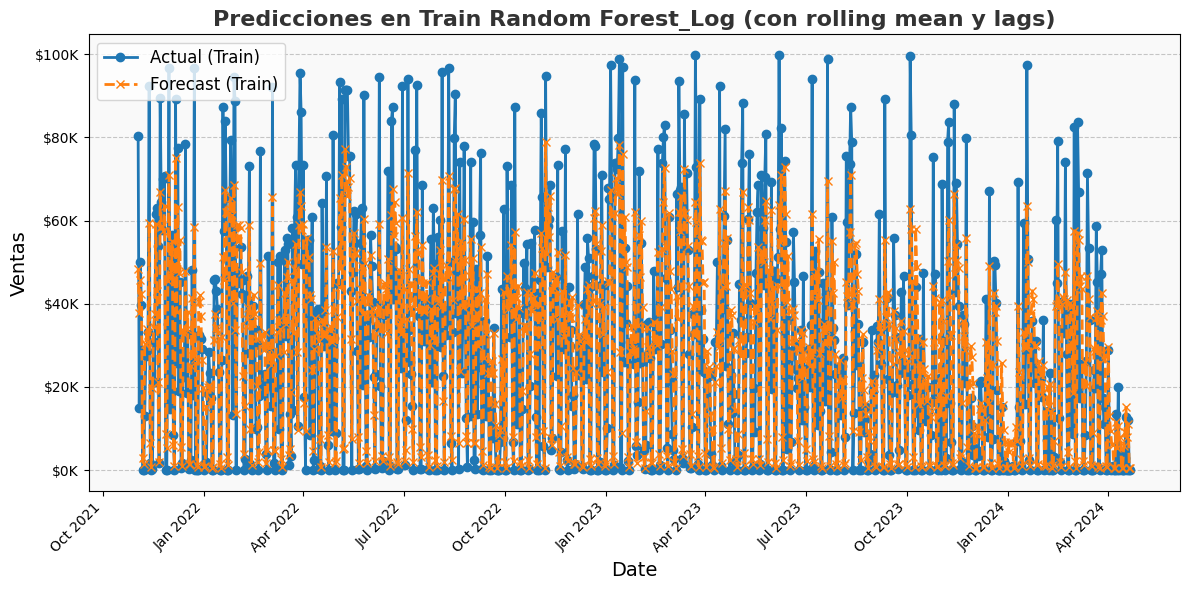

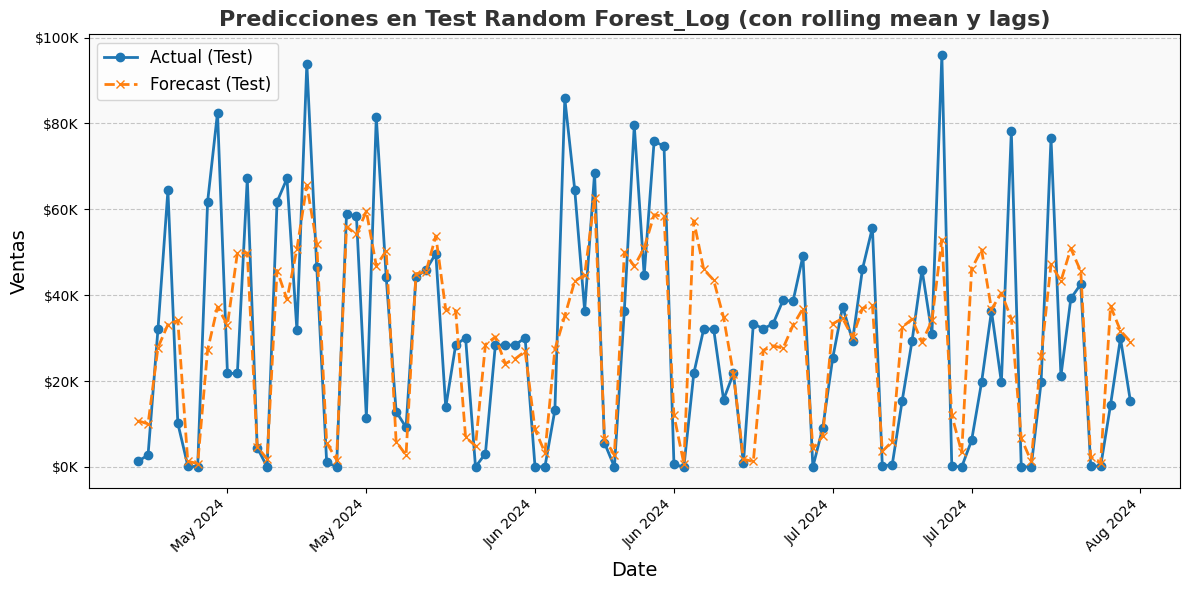

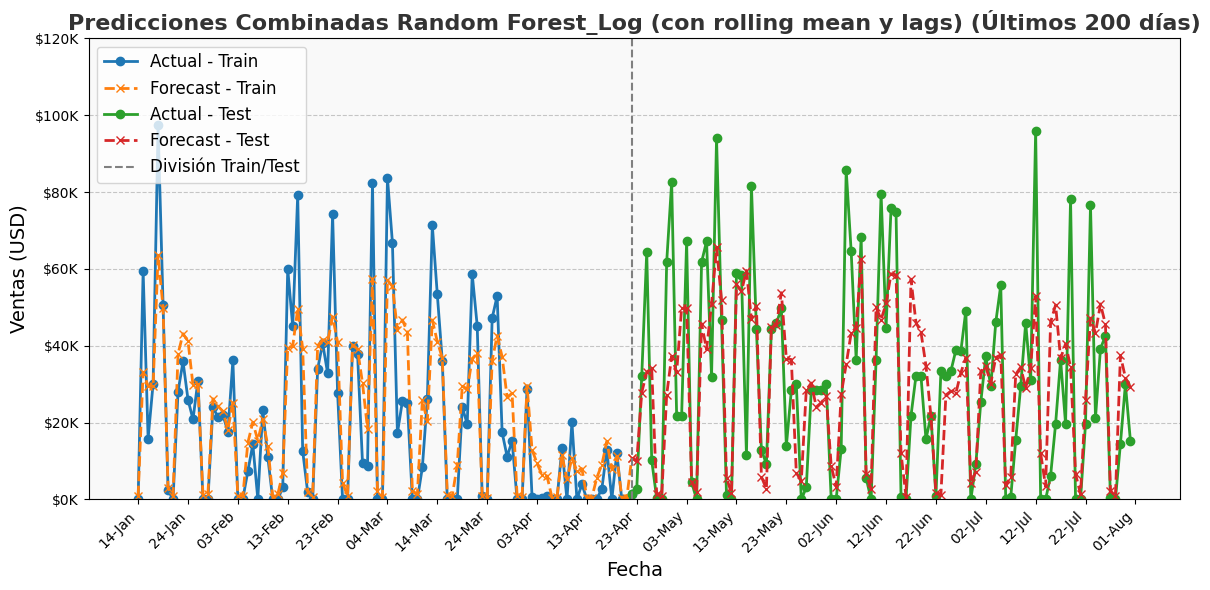

In [18]:
model_log = RandomForestTimeSeriesLog(data=data, target='Ventas_Log', test_days=101)
model_log.preprocess_data()
model_log.train_model()
model_log.evaluate_model_predictions()
model.plot_predictions(train_title='Predicciones en Train Random Forest_Log (con rolling mean y lags)',
    test_title='Predicciones en Test Random Forest_Log (con rolling mean y lags)',
    divided_title='Predicciones Combinadas Random Forest_Log (con rolling mean y lags) (Últimos 200 días)'
)

In [19]:
model_info_log = model_log.generate_model_info(version='Random Forest Log')

In [20]:
df_models_info = pd.concat([df_models_info, pd.DataFrame([model_info_log])], ignore_index=True)
df_models_info 

,version,model_name,rmse_train,mae_train,r2_train,rmse_test,mae_test,r2_test
0,Random Forest,RandomForestRegressor,12982.650000,9312.880000,0.780000,18095.000000,12965.150000,0.520000
1,Random Forest Log,RandomForestRegressor,12031.715995,6681.630515,0.814555,20360.287675,13557.833087,0.391055


### 5. Exportar Resultados

In [21]:
ruta = r'C:\Users\fsanc\OneDrive - Universidad EAFIT\Documentos\Pipe\OneDrive - Universidad EAFIT\Maestría\Trabajo de Grado\Results\random_forest.csv'
df_models_info.to_csv(ruta, index=False)